<a href="https://colab.research.google.com/github/mairovitzmario/data_science_notebooks/blob/main/fake_news.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Download libraries

In [ ]:
! pip install -q kaggle

# 0. Import libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay


# 1. Load Kaggle data

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 70 bytes


In [ ]:
!kaggle datasets download "razanaqvi14/real-and-fake-news"

Dataset URL: https://www.kaggle.com/datasets/razanaqvi14/real-and-fake-news
License(s): CC-BY-NC-SA-4.0
real-and-fake-news.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip /content/real-and-fake-news.zip

Archive:  /content/real-and-fake-news.zip
replace Fake.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace True.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
df_fake = pd.read_csv('/content/Fake.csv')
df_true = pd.read_csv('/content/True.csv')

In [ ]:
df_fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [ ]:
df_true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


# 2. Process Data

## 2.1. Join dataframes

In [ ]:
df_fake['label'] = 0
df_true['label'] = 1

In [ ]:
df = pd.concat([df_fake, df_true])

In [ ]:
df.head()

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


## 2.2. Clean & Visualize data

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44898 entries, 0 to 21416
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   label    44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 2.1+ MB


In [ ]:
df.isnull().sum()

,0
title,0
text,0
subject,0
date,0
label,0


In [ ]:
df['label'].value_counts()

,count
label,
0,23481
1,21417


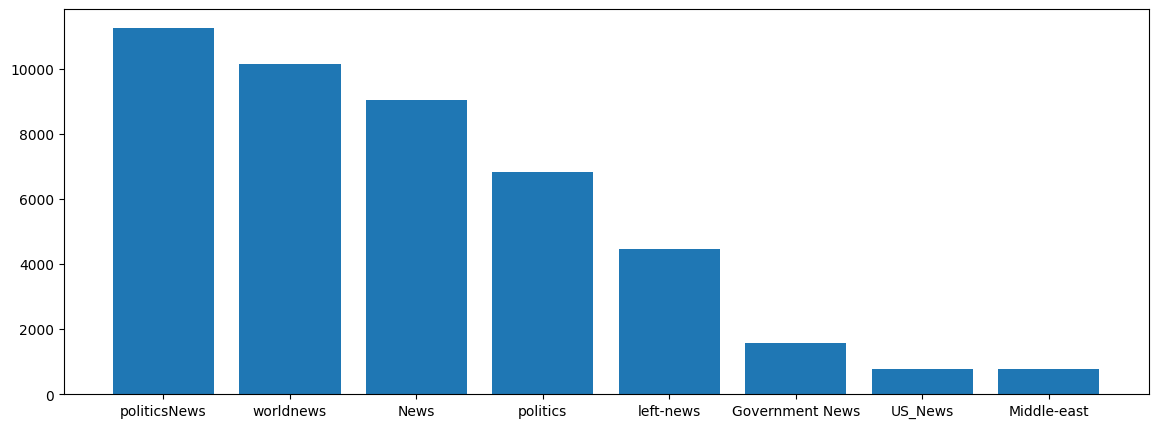

In [ ]:

plt.figure(figsize=(14, 5))
plt.bar(df['subject'].value_counts().index, df['subject'].value_counts())
plt.xticks(rotation=0)
plt.show()


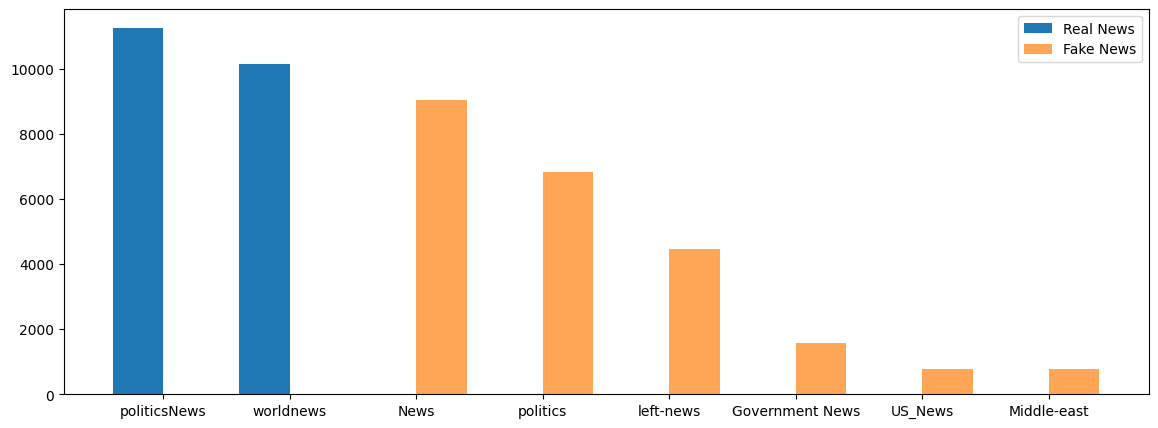

In [ ]:
labels = df['subject'].value_counts().index

values_true = df[df['label'] == 1]['subject'].value_counts().reindex(labels, fill_value=0)
values_false = df[df['label'] == 0]['subject'].value_counts().reindex(labels, fill_value=0)

x = np.arange(len(labels))  # label positions
width = 0.4  # width of each bar

plt.figure(figsize=(14, 5))

plt.bar(x - width/2, values_true, width, label='Real News')
plt.bar(x + width/2, values_false, width, label='Fake News', alpha=0.7)

plt.xticks(x, labels, rotation=0)
plt.legend()
plt.show()

In [ ]:
df[(df['label']==0) & (df['subject'] == 'worldnews')]

,title,text,subject,date,label


The subject categories of the real and fake news are labeled differently. One option is to label them PoliticsNews and WorldNews, however those 2 categories are really vague and I think it is best to drop this column.

In [ ]:
df.drop('subject', axis=1, inplace=True)

Also dropping date column

In [ ]:
df.drop('date', axis=1, inplace=True)

In [ ]:
df.head()

,title,text,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,0


## 2.3. Prepare input data

In [ ]:
df['news'] = df['title'] + '\n' + df['text']

In [ ]:
df.head()

,title,text,label,news
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,0,Donald Trump Sends Out Embarrassing New Year’...
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,0,Drunk Bragging Trump Staffer Started Russian ...
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",0,Sheriff David Clarke Becomes An Internet Joke...
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",0,Trump Is So Obsessed He Even Has Obama’s Name...
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,0,Pope Francis Just Called Out Donald Trump Dur...


Vectorizing the text

In [ ]:
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_vectors_dirty_tfid = vectorizer.fit_transform(df['news'])

vectorizer = CountVectorizer(max_features=5000, stop_words='english')
X_vectors_dirty_count = vectorizer.fit_transform(df['news'])

# 4. Prediction

In [ ]:
 def evaluate_models(X_train, X_test, y_train, y_test):
    models = {
        'Logistic Regression': LogisticRegression(max_iter=1000),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
        # 'SVM': SVC(kernel='linear', probability=True, random_state=42) too slow
    }

    accuracies = {}

    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        accuracies[name] = acc

        print(f"\n{name} Accuracy: {acc:.4f}")
        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
        disp.plot()
        plt.title(f'Confusion Matrix - {name}')
        plt.show()

    print("\nSummary of accuracies:")
    print(accuracies)
    return accuracies



Logistic Regression Accuracy: 0.9788


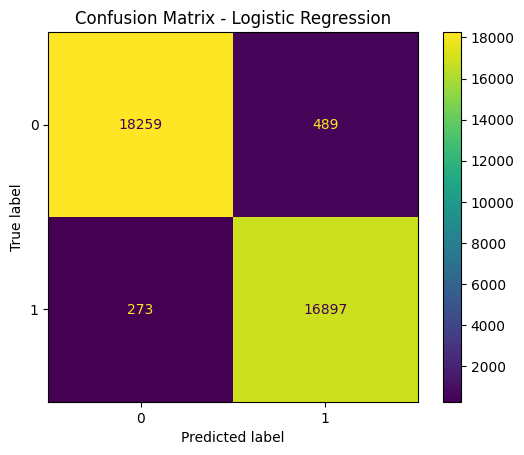


Random Forest Accuracy: 0.9950


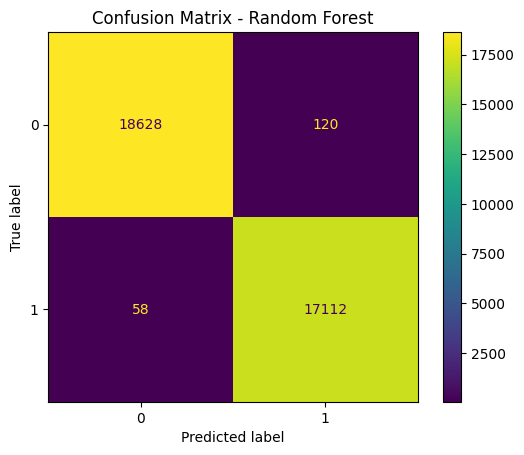


Summary of accuracies:
{'Logistic Regression': 0.9787850103012418, 'Random Forest': 0.9950442674981903}


{'Logistic Regression': 0.9787850103012418,
 'Random Forest': 0.9950442674981903}

In [ ]:
x_test, x_train, y_test, y_train = train_test_split(X_vectors_dirty_tfid, df['label'], test_size=0.2, random_state=42)

evaluate_models(x_train, x_test, y_train, y_test)


Logistic Regression Accuracy: 0.9911


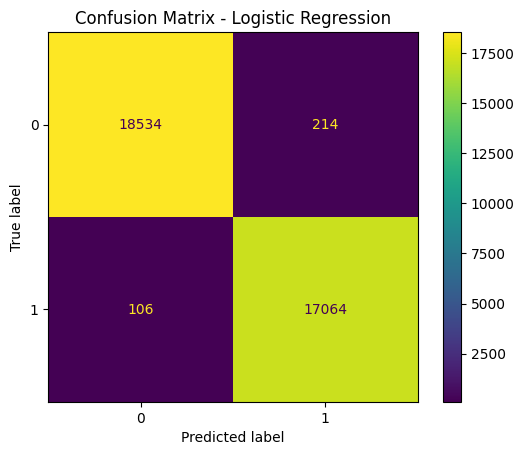


Random Forest Accuracy: 0.9955


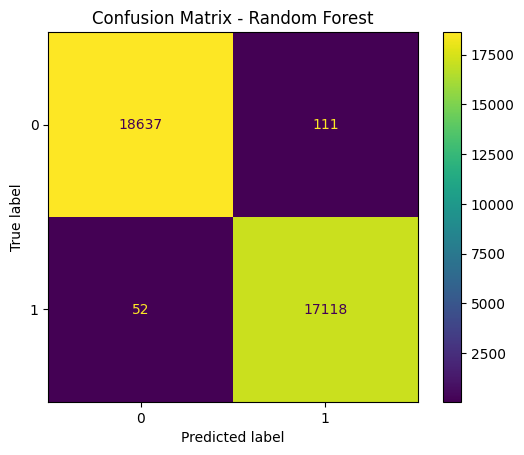


Summary of accuracies:
{'Logistic Regression': 0.9910908179742748, 'Random Forest': 0.9954618854056462}


{'Logistic Regression': 0.9910908179742748,
 'Random Forest': 0.9954618854056462}

In [ ]:
x_test, x_train, y_test, y_train = train_test_split(X_vectors_dirty_count, df['label'], test_size=0.2, random_state=42)

evaluate_models(x_train, x_test, y_train, y_test)

Logistic Regression performed better with the count vectorizer.  
No difference for random forest